In [1]:
from datetime import datetime, timedelta
import os
import sys
from glob import glob

import pandas as pd
import xarray as xr
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
from matplotlib import pyplot as plt

PACKAGE_DIR = os.path.dirname(os.getcwd())
sys.path.append(PACKAGE_DIR)

from ensabc.util.plot import iterate_stamp_plot

In [2]:
batch=datetime(2023, 8, 6, 12)
step = 240
var = '2t'

In [3]:
source = "ecmwf-enfo"
local_nc = os.path.join(PACKAGE_DIR, f'data/{source}-{batch:%Y%m%d%H}-{step:02}-{var}.nc')
ds = xr.open_dataset(local_nc)
centerlon = 110
centerlat = 45

### Spaghetti Plot

In [308]:
local_nc = os.path.join(PACKAGE_DIR, f'data/{source}-{batch:%Y%m%d%H}-*-{var}.nc')
mds = xr.open_mfdataset(sorted(glob(local_nc)))
df = mds.sel(longitude=centerlon, latitude=centerlat, method='nearest')[var].to_dataframe()
df = df[var].reset_index()

<AxesSubplot:xlabel='time'>

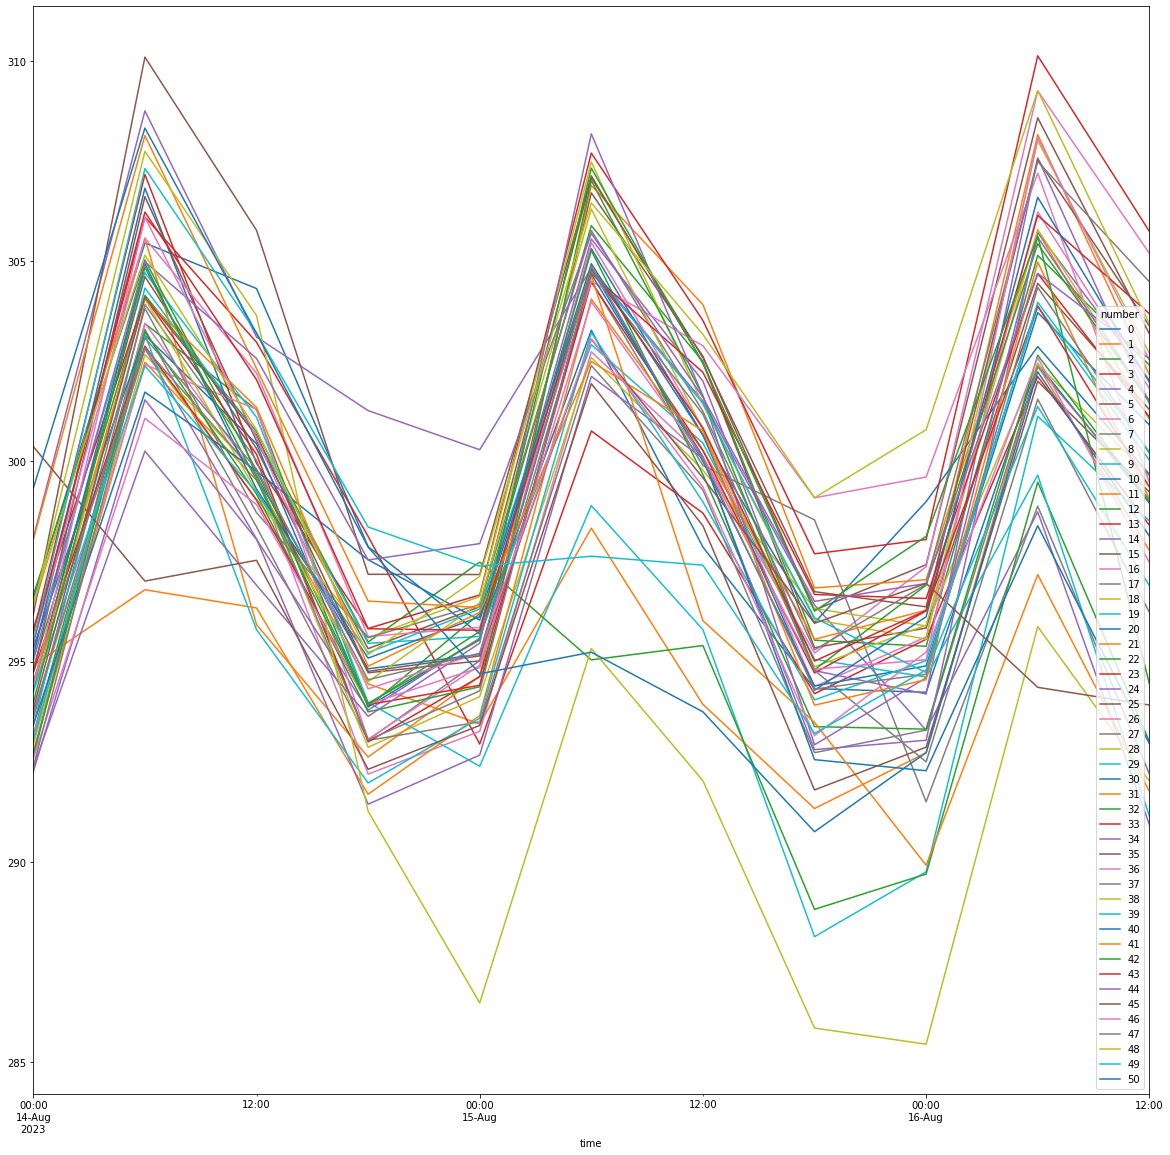

In [330]:
pd.pivot_table(df, values='2t', columns=['number'],index=['time']).plot(figsize=(20,20))

### Spread

## Map Product

In [4]:
slicelon = slice(centerlon-10,centerlon+10)
slicelat = slice(centerlat+10,centerlat-10)
small_da = ds[var].sel(longitude=slicelon,latitude=slicelat)
lons =small_da.longitude.values
lats = small_da.latitude.values

### Ensemble Map Stamp

In [5]:
def enumerate_iter_number(da:xr.DataArray):
    for i, n in enumerate(da['number'].values):
        data_ = da.sel(number=n).values
        yield i, data_.reshape(data_.shape[-2:])

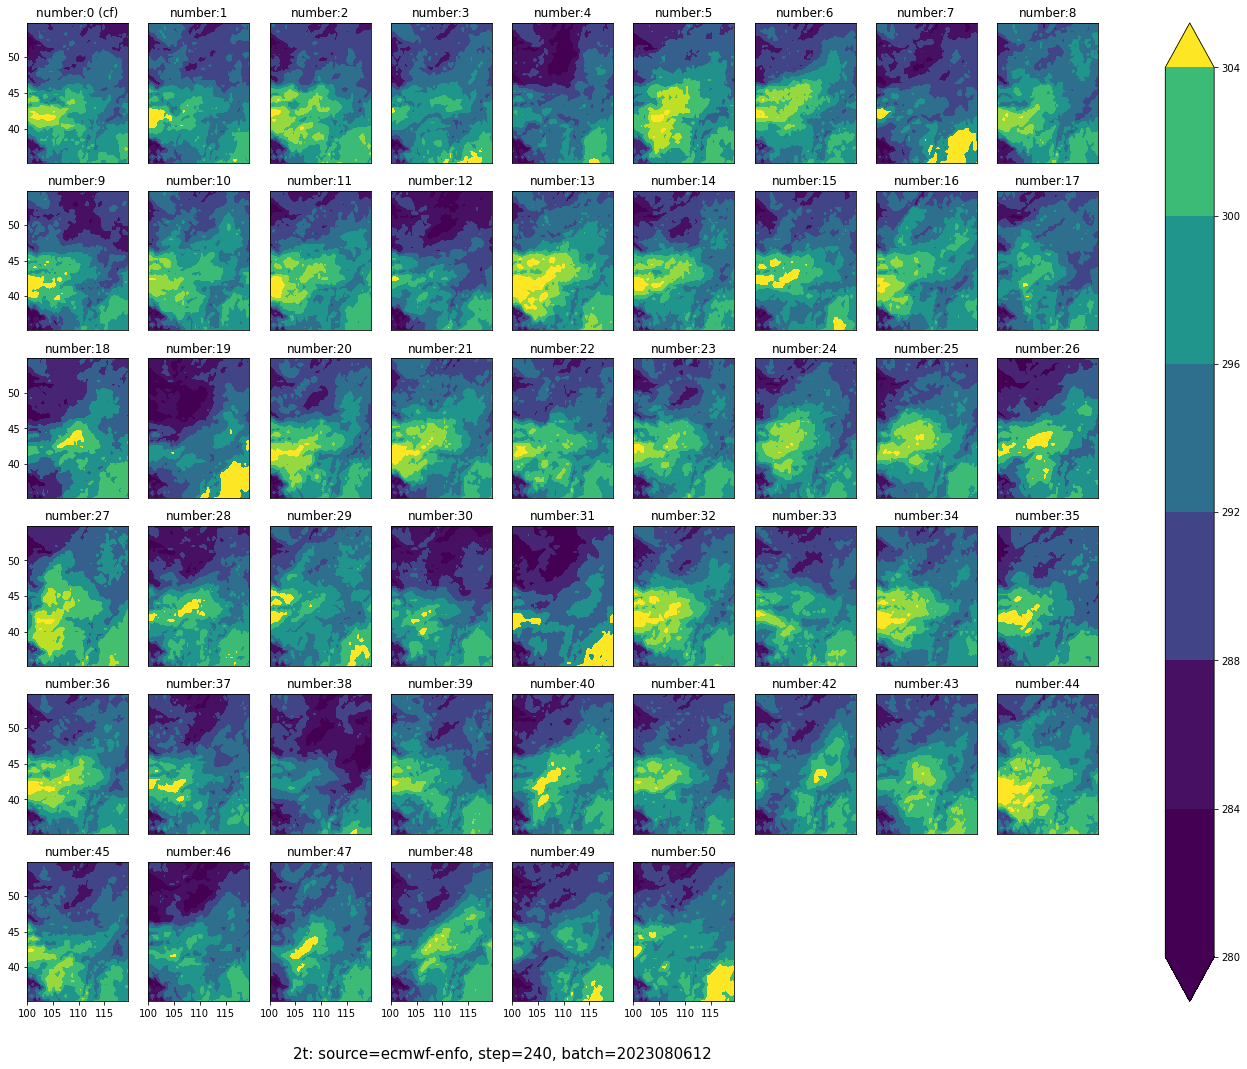

In [14]:
iterate_stamp_plot(
    enumerate_iter_number(small_da), 
    x=lons,
    y=lats,
    row=6,
    subtitle_pattern=['number:{idx} (cf)']+ ['number:{idx}' for i in range(1,51)],
    suptitle=f'{var}: source={source}, step={step}, batch={batch:%Y%m%d%H}',
    vmin=285, 
    vmax=310,
    extend='both',
    figsize=(24,18)
)
print()

In [15]:
data = small_da.values
xdata = data.reshape((data.shape[1],np.cumprod(data.shape[2:])[-1]))
xdata_std = StandardScaler().fit_transform(xdata)

In [16]:
sklearn_pca = sklearnPCA(n_components=2)
ydata_sklearn = sklearn_pca.fit_transform(xdata_std)
cluster_number = 3
kmeans = KMeans(n_clusters=cluster_number, random_state=0, n_init="auto").fit(ydata_sklearn)
labels = kmeans.labels_

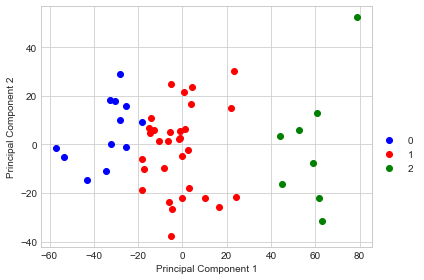

In [17]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(list(range(cluster_number)),
                    ['blue', 'red', 'green','orange','brown','gray'][:cluster_number]):
        plt.scatter(ydata_sklearn[labels==lab,0],
                    ydata_sklearn[labels==lab,1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(0.65, 0., 0.5, 0.5))
    plt.tight_layout()
    plt.show()

In [18]:
def enumerate_iter_cluster_mean(labels:np.array, da:xr.DataArray):
    data = da.values
    for i in range(labels.min(),labels.max()+1):
        yield i, data[0,labels==i,:,:].mean(axis=0).reshape(data.shape[-2:])

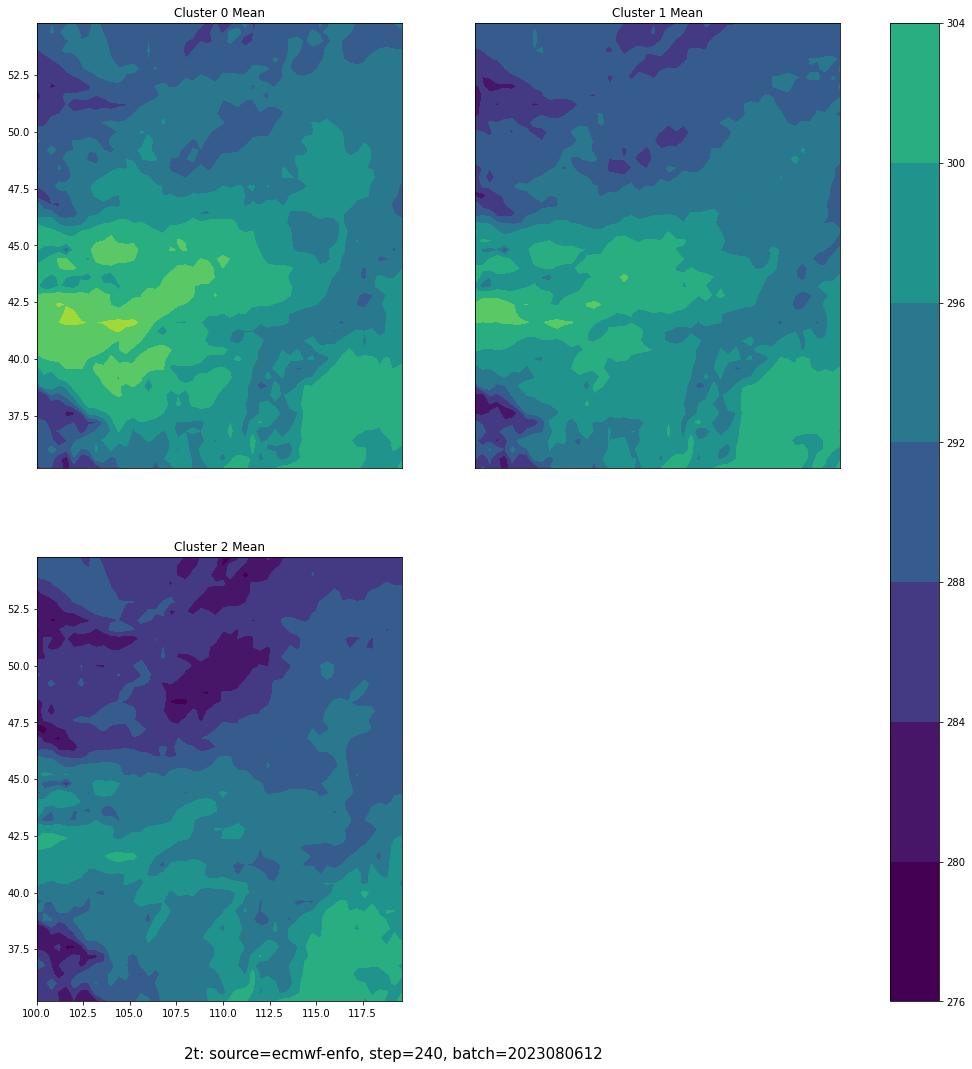

In [33]:
iterate_stamp_plot(
    enumerate_iter_cluster_mean(labels, small_da), 
    x=lons,
    y=lats,
    row=2,
    subtitle_pattern='Cluster {idx} Mean',
    suptitle=f'{var}: source={source}, step={step}, batch={batch:%Y%m%d%H}',
    vmin=280, 
    vmax=315,
    extend='neither',
    figsize=(18,18)
)
print()

In [21]:
def enumerate_iter_cluster_ensemble(label_value:int,labels:np.array, da:xr.DataArray):
    data = da.values
    n = 0
    yield 0, data[0,labels==label_value,:,:].mean(axis=0).reshape(data.shape[-2:])
    for i in np.where(labels==label_value)[0]:
        n += 1
        yield i, data[0, i, :, :]

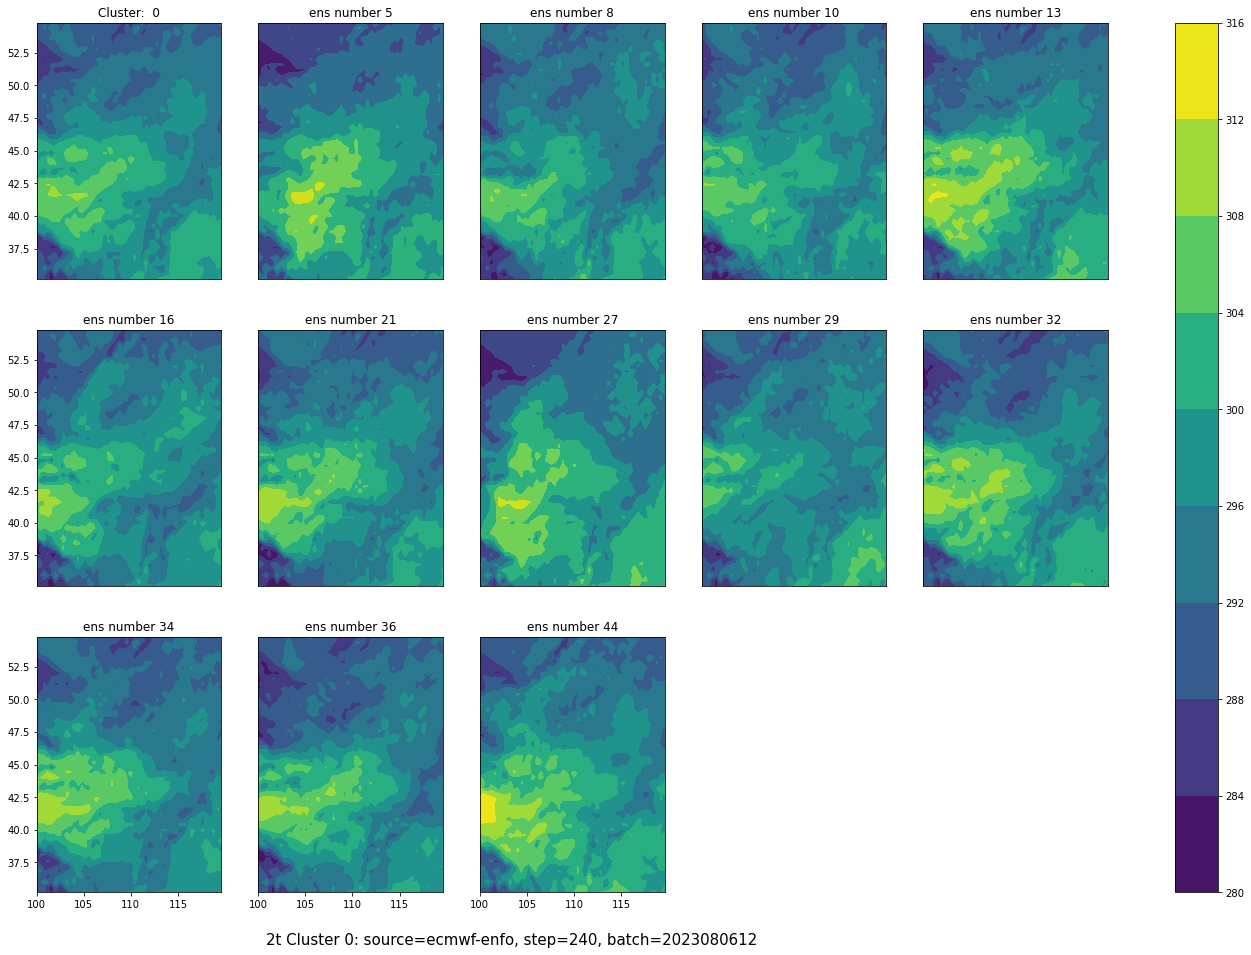

In [34]:
cluster_idx = 0
fig = iterate_stamp_plot(
    enumerate_iter_cluster_ensemble(cluster_idx, labels, small_da), 
    x=lons,
    y=lats,
    row=3,
    subtitle_pattern=[f'Cluster:  {cluster_idx}'] + [f'ens number {i}' for i in small_da.number[np.where(labels==cluster_idx)].to_series()],
    suptitle=f'{var} Cluster {cluster_idx}: source={source}, step={step}, batch={batch:%Y%m%d%H}',
    vmin=280, 
    vmax=315,
    extend='neither',
    figsize=(24,16)
)

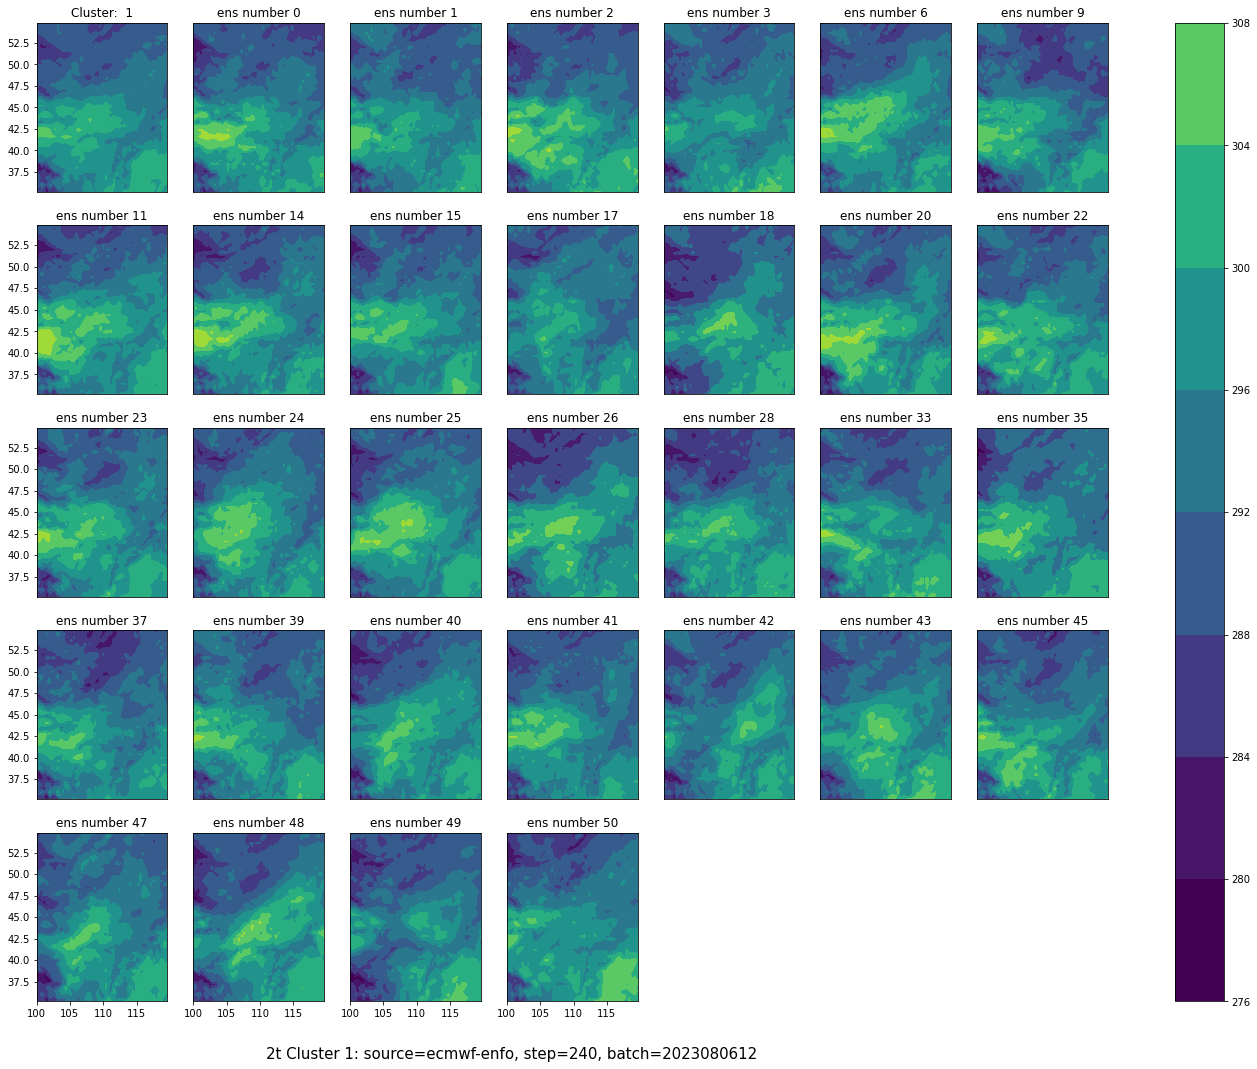

In [35]:
cluster_idx = 1
fig = iterate_stamp_plot(
    enumerate_iter_cluster_ensemble(cluster_idx, labels, small_da), 
    x=lons,
    y=lats,
    row=5,
    subtitle_pattern=[f'Cluster:  {cluster_idx}'] + [f'ens number {i}' for i in small_da.number[np.where(labels==cluster_idx)].to_series()],
    suptitle=f'{var} Cluster {cluster_idx}: source={source}, step={step}, batch={batch:%Y%m%d%H}',
    vmin=280, 
    vmax=315,
    extend='neither',
    figsize=(24,18)
)

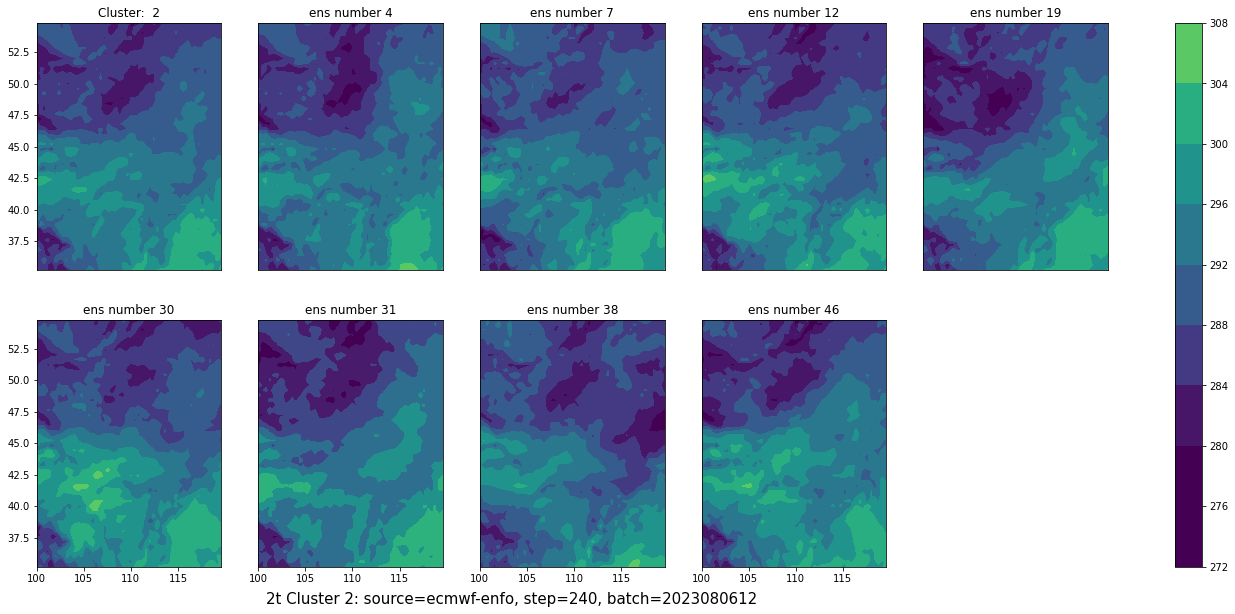

In [36]:
cluster_idx = 2
fig = iterate_stamp_plot(
    enumerate_iter_cluster_ensemble(cluster_idx, labels, small_da), 
    x=lons,
    y=lats,
    row=2,
    subtitle_pattern=[f'Cluster:  {cluster_idx}'] + [f'ens number {i}' for i in small_da.number[np.where(labels==cluster_idx)].to_series()],
    suptitle=f'{var} Cluster {cluster_idx}: source={source}, step={step}, batch={batch:%Y%m%d%H}',
    vmin=280, 
    vmax=315,
    extend='neither',
    figsize=(24,10)
)

### Solution